In [8]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.merge import merge
from matplotlib.colors import ListedColormap
import numpy as np
from rasterio import mask
import boto3
import geopandas as gpd
import subprocess
import sys
import os
import rioxarray

In [2]:
sys.path.append(os.path.expanduser('../../'))
from scripts.utils.write_metadata import (
    make_metadata_files, 
    append_metadata
)

from scripts.utils.file_helpers import to_zarr

In [11]:
def impervious_stitch_reproject_clip(output_file):
    '''
    Stitches three tiff files containing CA impervious surface data according to geospatial coordinates and creates one tiff file. This
    file is reprojected to CA census tract boundary data, then clipped to eliminate data from neighboring states and the ocean. The resulting
    file is converted to a zarr file and uploaded to AWS

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance
    
    Parameters
    ----------
    output_file_name: string
        Final output name, without any extension
    '''
    s3_client = boto3.client('s3')  
    bucket_name = 'ca-climate-index'  
    pull_directory = f'1_pull_data/natural_systems/ecosystem_condition/usgs/impervious_lands/'

    # Check if files are already present locally
    pull_files = ['NLCD_2021_Impervious_descriptor_L48_20230630_7chgdhjK0Tm5jDnY3UFC.tiff',
                   'NLCD_2021_Impervious_descriptor_L48_20230630_D4ybQQaC64JAda5AzFne.tiff',
                   'NLCD_2021_Impervious_descriptor_L48_20230630_QrVaSuoYo0fR1Zf54FY1.tiff']
    
    print('Pulling large files from AWS, this could take a few minutes...')
    
    for pull_file in pull_files:
        if not os.path.exists(pull_file):
            # File not found locally, download from S3
            pull_path = os.path.join(pull_directory, pull_file)
            s3_client.download_file(bucket_name, pull_path, pull_file)
    
    central_data = "NLCD_2021_Impervious_descriptor_L48_20230630_QrVaSuoYo0fR1Zf54FY1.tiff"
    northern_data = "NLCD_2021_Impervious_descriptor_L48_20230630_D4ybQQaC64JAda5AzFne.tiff"
    southern_data = "NLCD_2021_Impervious_descriptor_L48_20230630_7chgdhjK0Tm5jDnY3UFC.tiff"

    input_files = [central_data, northern_data, southern_data]
    print(f'Pull complete, input files: {input_files} are being stitched together..')
    print('')
    bounds = (-2629335.0, 1187895.0, -1469865.0, 2470635.0)  # Adjusted bounds covering all three regions

    src_files_to_mosaic = [rasterio.open(file) for file in input_files]

    # Merge the rasters
    mosaic, out_trans = merge(src_files_to_mosaic, bounds=bounds)

    # Update metadata for the merged raster
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans})

    # Write the merged raster to a new file
    with rasterio.open("ca_merged_impervious.tiff", "w", **out_meta) as dest:
        dest.write(mosaic)

    # Selecting band to visualize (always 1 in for this dataset)
    selected_band = 1
    ca_merged = 'ca_merged_impervious.tiff'
    print('Merge complete, creating visual')
    
    # Open the GeoTIFF file
    with rasterio.open(ca_merged) as dataset:
        # Read the selected band
        band_data = dataset.read(selected_band)

        # Downscale the data (origional very taxing on computer)
        scale_factor = 0.2
        band_data_downscaled = band_data[::int(1/scale_factor), ::int(1/scale_factor)]

        # Display the downscaled raster
        plt.figure(figsize=(10, 10))
        plt.imshow(band_data_downscaled, cmap='viridis', interpolation='none')

        plt.title(f'California Impervious Surfaces, three datasets stitched (Downscaled)')
        plt.colorbar(label='Pixel Value')
        plt.show()
    
    print('pulling census data from AWS...')
    # load the census tracts spatial data for California
    census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
    ca_boundaries = gpd.read_file(census_shp_dir)
    # check the current coordinate system of the census tracts data
    print("Original CRS of Census Tracts Data:")
    print(ca_boundaries.crs)
    print('')
    target_epsg = 4269
   
   
    # Open the GeoTIFF file
    with rasterio.open(ca_merged) as dataset:
        # Check the CRS
        srs = dataset.crs
        print("Spatial Reference System (SRS) of Impervious data:", srs)
        print('')

    print(f'Reprojecting to {ca_boundaries.crs}')
    print('')
    
    subprocess.run(["gdalwarp", "-t_srs", f"EPSG:{target_epsg}", ca_merged, 'ca_reprojected_impervious.tiff'])

    
    ca_reproject = 'ca_reprojected_impervious.tiff'
    # Open the reprojected raster file
    with rasterio.open(ca_reproject) as dataset:
        # Check the CRS
        srs_reprojected = dataset.crs
        print(f'New Spatial Reference Impervious Surfaces: {srs_reprojected}')    
    
    selected_band = 1
    
    print('Complete, now visualizing reprojected data')
    
    # Open the GeoTIFF file
    with rasterio.open(ca_reproject) as dataset:
        # Read the selected band
        band_data = dataset.read(selected_band)

        # Downscale the data
        scale_factor = 0.2
        band_data_downscaled = band_data[::int(1/scale_factor), ::int(1/scale_factor)]

        # Create a custom colormap with white background
        cmap_white_bg = ListedColormap(['white'] + plt.cm.viridis.colors)

        # Display the downscaled raster with a white background
        plt.figure(figsize=(10, 10))
        plt.imshow(band_data_downscaled, cmap=cmap_white_bg, interpolation='none', vmin=np.min(band_data_downscaled), vmax=np.max(band_data_downscaled), clim=(0,1))

        plt.title(f'California Impervious Surfaced, Reprojected to CA Census Boundaries (Downscaled)')
        plt.colorbar(label='Pixel Value')
        plt.show()

    print('Now clipping data to census boundaries to eliminate ocean and neighboring state data')
    print('')
    
    # Ensure that the geometries are in the same coordinate reference system
    ca_boundaries = ca_boundaries.to_crs(crs={'init': 'epsg:4269'})

    # Open the reprojected raster file
    with rasterio.open(ca_reproject) as src:
        # Use the geometry of the source file to clip the raster
        clipped_data, clipped_transform = mask.mask(src, ca_boundaries.geometry, crop=True)

        # Update the metadata with the new bounds and transform
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            'driver': 'GTiff',
            'height': clipped_data.shape[1],
            'width': clipped_data.shape[2],
            'transform': clipped_transform
        })

        # Write the clipped raster to a new file
        clipped_tiff = output_file
        with rasterio.open(clipped_tiff, 'w', **clipped_meta) as dest:
            dest.write(clipped_data)
    
    print('Complete, now visualizing impervious surface data for CA exclusively')
    print('')     
    selected_band = 1

    # Open the GeoTIFF file
    with rasterio.open(clipped_tiff) as dataset:
        # Read the selected band
        band_data = dataset.read(selected_band)

        # Downscale the data
        scale_factor = 0.2
        band_data_downscaled = band_data[::int(1/scale_factor), ::int(1/scale_factor)]

        # Create a custom colormap with white background
        cmap_white_bg = ListedColormap(['white'] + plt.cm.viridis.colors)

        # Display the downscaled raster with a white background
        plt.figure(figsize=(10, 10))
        plt.imshow(band_data_downscaled, cmap=cmap_white_bg, interpolation='none', vmin=np.min(band_data_downscaled), vmax=np.max(band_data_downscaled), clim=(0,1))

        plt.title(f'California Impervious Surfaces, Clipped to CA Census Boundaries (Downscaled)')
        plt.colorbar(label='Pixel Value')
        plt.show()
            
    # Open the GeoTIFF file using xarray
    ds = rioxarray.open_rasterio(clipped_tiff)     
           
    to_zarr(ds, '2b_reproject', 'natural_systems', 'ecosystem_condition', 'usgs', output_file)
    print(f'Success, file {output_file}.zarr uploaded to AWS!') 

Pulling large files from AWS, this could take a few minutes...
Pull complete, input files: ['NLCD_2021_Impervious_descriptor_L48_20230630_QrVaSuoYo0fR1Zf54FY1.tiff', 'NLCD_2021_Impervious_descriptor_L48_20230630_D4ybQQaC64JAda5AzFne.tiff', 'NLCD_2021_Impervious_descriptor_L48_20230630_7chgdhjK0Tm5jDnY3UFC.tiff'] are being stitched together..

Merge complete, creating visual


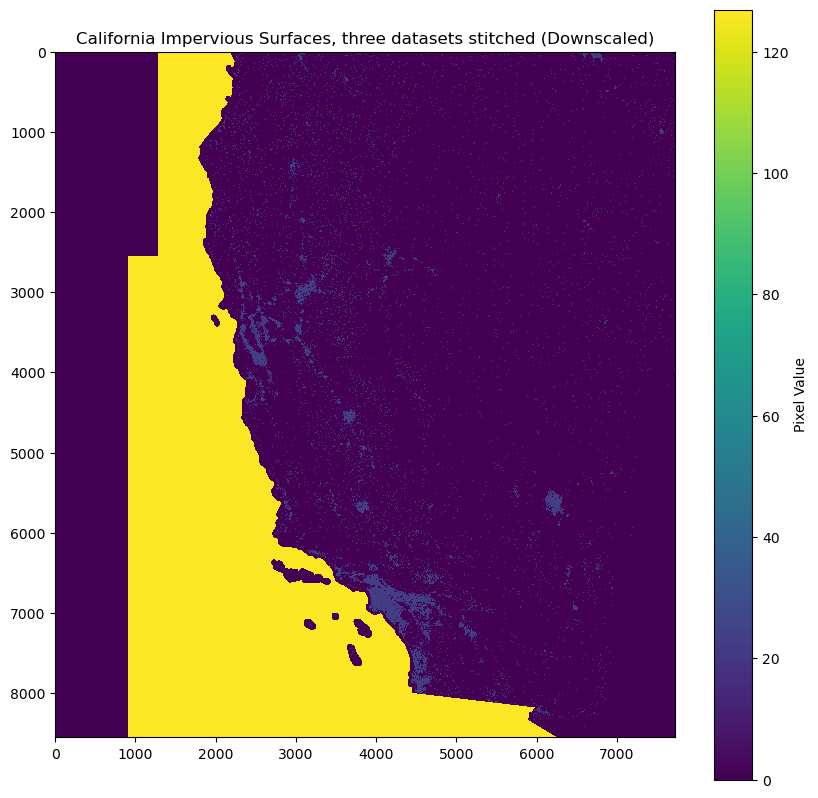

pulling census data from AWS...
Original CRS of Census Tracts Data:
EPSG:4269

Spatial Reference System (SRS) of Impervious data: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Reprojecting to EPSG:4269

New Spatial Reference Impervious Surfaces: EPSG:4269
Complete, now visualizing reprojected data


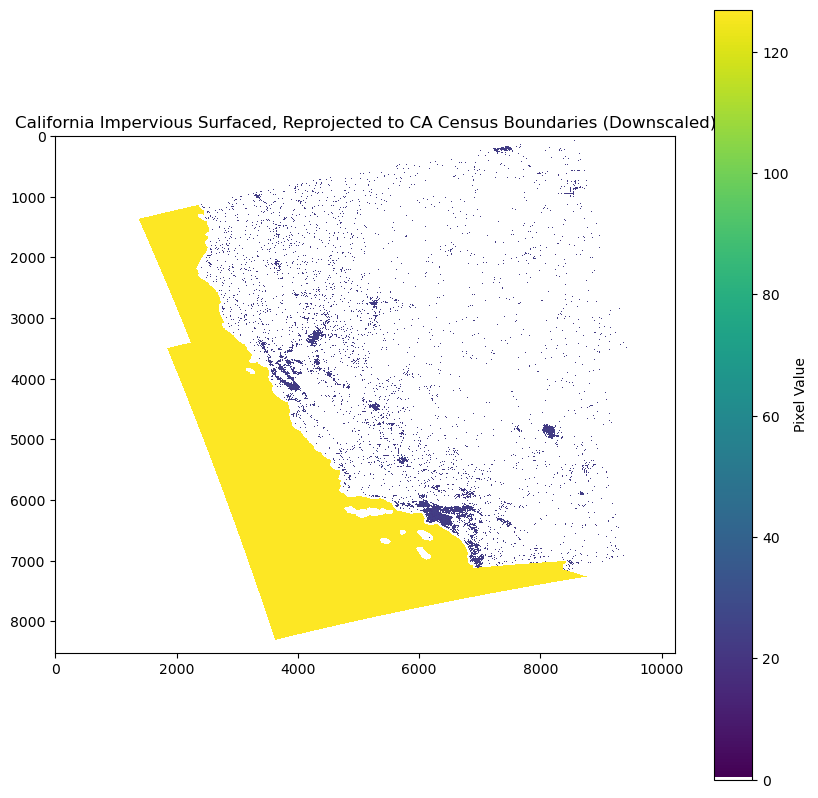

Now clipping data to census boundaries to eliminate ocean and neighboring state data



c:\Users\jesse\miniconda3\envs\carb\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Complete, now visualizing impervious surface data for CA exclusively



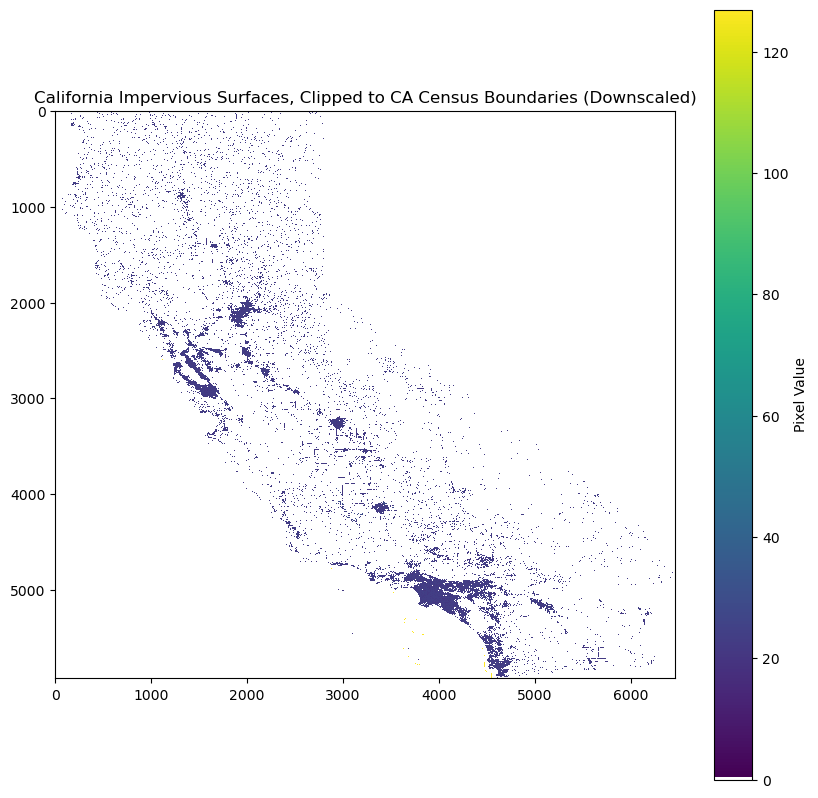

Success, file ca_reprojected_clipped_impervious_surfaces.zarr uploaded to AWS!


In [10]:
output_file = 'ca_reprojected_clipped_impervious_surfaces'
impervious_stitch_reproject_clip(output_file)